In [1]:
import networkx as nx
import numpy as np
import random as rand
import scipy
from matplotlib.pyplot import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mutual_info_score
import os
from math import sqrt
import json
from statistics import mean


In [2]:
def get_cyclic_net(filename):
    G=nx.read_edgelist(filename, comments='#', delimiter="\t", nodetype =str,  data=(('mode',str),), create_using=nx.DiGraph())
    G.remove_nodes_from(["Source", "Target"])
    selfloops=G.selfloop_edges()
    G.remove_edges_from(G.selfloop_edges())
    
    while 0 in G.in_degree().values() or 0 in G.out_degree().values():
        nodes_to_remove=[node for node in G if G.in_degree(node) == 0 or G.out_degree(node) == 0]
        G.remove_nodes_from(nodes_to_remove)
        
    selfloops_in_reservoir=[edge for edge in selfloops if edge[0] in G.nodes()]
    G.add_edges_from(selfloops_in_reservoir)
    return G

In [3]:
class ESN(object):
    def __init__(self, filename, in_size, out_size, spectral_radius):
        self.res_size= self.build_adj_weighted_matrix(filename).shape[0]
        self.in_size=in_size
        self.out_size=out_size
        self.spectral_radius= spectral_radius
        self.W0=self.build_adj_weighted_matrix(filename)
        self.W=None
        self.Win=None
        self.Wout=None
        self.X=None
        self.Y=None
        self.x=np.zeros((self.res_size,1))
        self.x0=np.random.rand(self.res_size)
        self.decay=np.random.rand((self.res_size))

    
    def build_adj_weighted_matrix(self, filename):
        net=get_cyclic_net(filename)
        for edge in net.edges_iter(data="mode", default=0):
            source,target,mode=edge
            if mode== "+":
                net[source][target]["weight"]= rand.uniform(0,1)
            elif mode== "-":
                net[source][target]["weight"]= rand.uniform(0,-1)
            elif mode== 0:
                net[source][target]["weight"]= rand.uniform(-1,1)
        return nx.to_numpy_matrix(net)
    
    def initialize(self): 
        np.random.seed(42)
        self.Win=np.random.choice([-0.5,0.5], size=(self.res_size,1+self.in_size))
        self.W0 = np.squeeze(np.asarray(self.W0))
        rhoW0 = max(abs(scipy.linalg.eig(self.W0)[0]))
        self.W= (self.spectral_radius/rhoW0)*self.W0
        

    def collect_states(self, data, init_len, train_len, a=0.3):
        self.X=np.zeros((self.res_size+self.in_size+1, train_len-init_len))
        for t in range(train_len):
            u = data[t]
            self.x = (1-a)*self.x + a*np.tanh( np.dot( self.Win, np.vstack((1,u)) ) + np.dot( self.W, self.x ) ) 
            if t >= init_len:
                self.X[:,t-init_len]= np.vstack((1,u,self.x))[:,0]
               
        return self.X
    
    def collect_states_derivative(self, data, init_len, train_len, n=0):
        self.X=np.zeros((self.res_size+self.in_size+1, train_len-init_len))
        t=np.arange(train_len)
        x=scipy.integrate.odeint(self.dx_dt,self.x0,t,args=(data,self.decay))
        self.x0=x[-1,:]
        for t in range(init_len-n,train_len-n):
            x_concat=x[t,:].reshape(x[t,:].shape[0],1)
            self.X[:,t-init_len]= np.vstack((1,data[t],x_concat))[:,0]
               
        return self.X
    
    def dx_dt(self, x,t,data,decay):
        print(t)
        x_updated= np.tanh( np.dot( self.Win, np.vstack((1,data[int(t)])) ) + np.dot( self.W, x ) ) - np.multiply(decay,x)
        return x_updated[0,:]
        
    
    def calculate_weights(self, data, init_len, train_len, beta=1e-8 ):
        Y=np.array([data[init_len:train_len]])
        X_T=self.X.T
        self.Wout= np.dot ( np.dot(Y, X_T), np.linalg.inv(np.dot(self.X,X_T) + beta * np.eye(self.res_size+self.in_size+1))) #w= y*x_t*(x*x_t + beta*I)^-1
        return self.Wout
    
    def run_predictive(self, data, test_len, train_len,a=0.3):
        self.Y = np.zeros((self.out_size,test_len))
        u = data[train_len] 
        for t in range(test_len):
            self.x = (1-a)*self.x + a*np.tanh( np.dot( self.Win, np.vstack((1,u)) ) + np.dot( self.W, self.x ) ) 
            y = np.dot( self.Wout, np.vstack((1,u,self.x)) )
            self.Y[:,t] = y
            u = data[train_len+t+1] 
        
        return self.Y
    
    def run_predictive_derivative(self, data, test_len, train_len,dt=1):
        self.Y = np.zeros((self.out_size,test_len))
        u = data[train_len]
        t=np.arange(test_len)
        x=scipy.integrate.odeint(self.dx_dt,self.x0,t,args=(data[train_len:],self.decay))
        for t in range(test_len-1):
            x_concat=x[t,:].reshape(x[t,:].shape[0],1)
            y = np.dot( self.Wout, np.vstack((1,u,x_concat)) )
            self.Y[:,t] = y
            u = data[train_len+t+1] 
        
        return self.Y



In [4]:
#NARMA 
def NARMA_task(steps, data, init_len, train_len):
        Y=np.zeros(train_len)
        for t in range(init_len,train_len):
            Y[t]=0.3* Y[t-1] + 0.05*Y[t-1]*np.sum(Y[t-1:t-steps])+ 1.5*data[t-steps]*data[t-1]+0.1
                
        return Y

In [5]:
def testing_gene_net(directory,data):
    csv_files= [file for file in os.listdir(directory) if file.startswith("network_edge_list")]

    for file in csv_files:
        net=ESN(os.path.join(directory, file),1,1,0.95)
        net.initialize()
        net.collect_states(data,initLen,trainLen)
        net.calculate_weights(data,initLen,trainLen)
        net.run_predictive(data,testLen,trainLen)
        
        nrmse= sqrt(mean_squared_error(data[trainLen+1:trainLen+errorLen+1],net.Y[0,0:errorLen])/np.std(net.Y[0,0:errorLen]))
        print(net.res_size, 'NRMSE = ' + str( nrmse ))
        
        
        plot( data[trainLen+1:trainLen+testLen+1], 'g' )
        plot( net.Y.T, 'b' )
        title('Target and generated signals $y(n)$ starting at $n=0$')
        legend(['Target signal', 'Free-running predicted signal'])
        show()
      

In [6]:
def testing_gene_net_derivative(directory,data,result):
    csv_files= [file for file in os.listdir(directory) if file.startswith("network_edge_list")]

    for file in csv_files:
        net=ESN(os.path.join(directory, file),1,1,0.95)
        net.initialize()
        net.collect_states_derivative(data,initLen,trainLen)
        print(net.res_size, " FINISHED")
        net.calculate_weights(data,initLen,trainLen)
        net.run_predictive_derivative(data,testLen,trainLen)
        nrmse= sqrt(mean_squared_error(result[trainLen+1:trainLen+errorLen+1],net.Y[0,0:errorLen])/np.std(net.Y[0,0:errorLen]))
        print(net.res_size, 'NRMSE = ' + str( nrmse ))

In [7]:
def testing_gene_net_derivative_with_n(file,data,n_size):
    Yt_res={}
    print(file)

    for n in range(n_size):
        print("n = "+str(n))
        net=ESN(file,1,1,0.95)
        net.initialize()
        net.collect_states_derivative(data,initLen,trainLen,n)
        net.calculate_weights(data,initLen,trainLen,n)
        net.run_predictive_derivative(data,testLen,trainLen)
        Yt_res[n]=net.Y
    print("FINISHED")
    return Yt_res
        

In [8]:
def calc_MI(x, y):
    bins=sqrt(x.shape[0]/5)
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [9]:
def memory_capacity_n(Yt_n, Y,i_size):
    MI_i={}
    for i in range(1,2*(i_size)+1):
        Yt_n=np.array(Yt_n)
        MI_i["i"+str(i)]=calc_MI(Y[200:800],Yt_n[0,200-i:800-i])
    return MI_i

In [10]:
##################################################################################


In [13]:
# TRAINING AND TEST LENGHT
errorLen = 500
trainLen=8000
testLen=1000
initLen=100

In [ ]:
##################################################################################


MACKEY GLASS
207 NRMSE = 0.06745088112631288


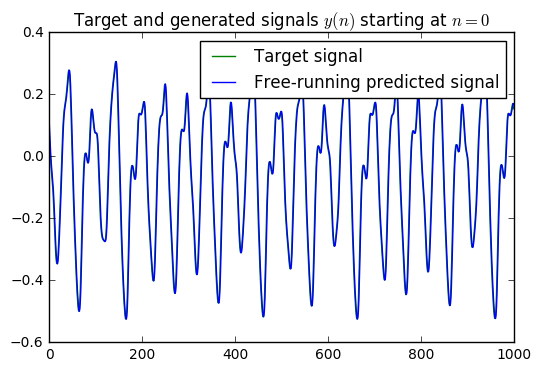

486 NRMSE = 0.06742974366738087


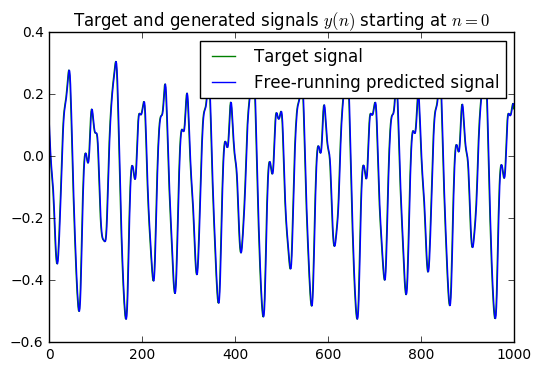

289 NRMSE = 0.06745507017313883


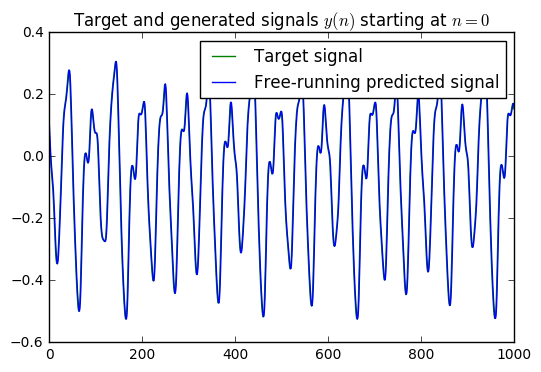

70 NRMSE = 0.06746241042661648


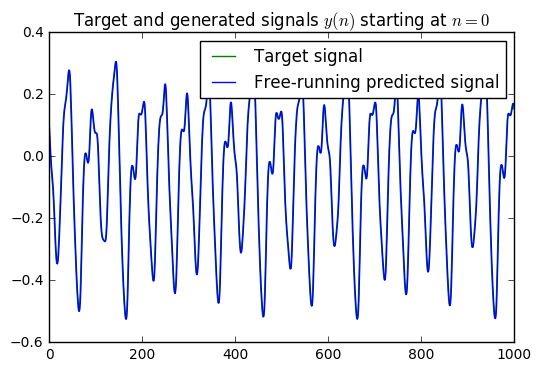

13 NRMSE = 0.06746322342520637


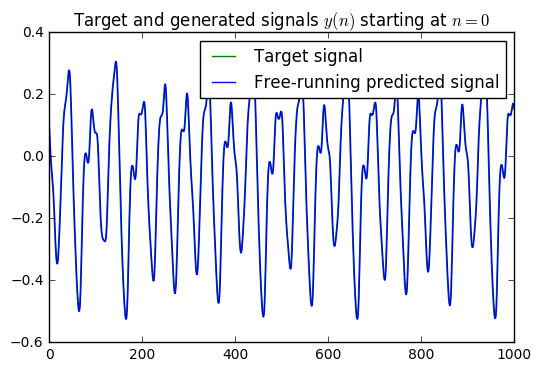

In [14]:
#MACKEY GLASS
data = np.loadtxt('MackeyGlass_t17.txt')
print("MACKEY GLASS")
testing_gene_net("Dataset1/",data)